<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Fine_tune_SegFormer_on_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are going to fine-tune `SegFormerForSemanticSegmentation` on a custom **semantic segmentation** dataset. In semantic segmentation, the goal for the model is to label each pixel of an image with one of a list of predefined classes.

We load the encoder of the model with weights pre-trained on ImageNet-1k, and fine-tune it together with the decoder head, which starts with randomly initialized weights.

In [ ]:
!pip install -q transformers datasets

     |████████████████████████████████| 3.8 MB 5.3 MB/s 
     |████████████████████████████████| 325 kB 64.0 MB/s 
     |████████████████████████████████| 6.5 MB 54.8 MB/s 
     |████████████████████████████████| 596 kB 59.5 MB/s 
     |████████████████████████████████| 895 kB 55.8 MB/s 
     |████████████████████████████████| 67 kB 7.1 MB/s 
     |████████████████████████████████| 134 kB 75.4 MB/s 
     |████████████████████████████████| 1.1 MB 51.9 MB/s 
     |████████████████████████████████| 212 kB 75.5 MB/s 
     |████████████████████████████████| 127 kB 75.4 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
     |████████████████████████████████| 271 kB 51.7 MB/s 
     |████████████████████████████████| 144 kB 57.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which i

## Download toy dataset

Here we download a small subset of the ADE20k dataset, which is an important benchmark for semantic segmentation. It contains 150 labels.

I've made a small subset just for demonstration purposes (namely the 10 first training and 10 first validation images + segmentation maps). The goal for the model is to overfit this tiny dataset (because that makes sure that it'll work on a larger scale).

In [ ]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/l1e45oht447053f/ADE20k_toy_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

Note that this dataset is now also available on the hub :) you can directly check out the images [in your browser](scene_parse_150)! It can be easily loaded as follows (note that loading will take some time as the dataset is several GB's large):

In [ ]:
from datasets import load_dataset

load_entire_dataset = False

if load_entire_dataset:
  dataset = load_dataset("scene_parse_150")

## Define PyTorch dataset and dataloaders

Here we define a [custom PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Each item of the dataset consists of an image and a corresponding segmentation map.

In [ ]:
from torch.utils.data import Dataset
import os
from PIL import Image

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)
        
        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)
        
        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

Let's initialize the training + validation datasets. Important: we initialize the feature extractor with `reduce_labels=True`, as the classes in ADE20k go from 0 to 150, with 0 meaning "background". However, we want the labels to go from 0 to 149, and only train the model to recognize the 150 classes (which don't include "background"). Hence, we'll reduce all labels by 1 and replace 0 by 255, which is the `ignore_index` of SegFormer's loss function.

In [ ]:
from transformers import SegformerFeatureExtractor

root_dir = '/content/ADE20k_toy_dataset'
feature_extractor = SegformerFeatureExtractor(reduce_labels=True)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, train=False)

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 10
Number of validation examples: 10


Let's verify a random example:

In [ ]:
encoded_inputs = train_dataset[0]

In [ ]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [ ]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [ ]:
encoded_inputs["labels"]

tensor([[255, 255, 255,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        ...,
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0,   0]])

In [ ]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104, 125,
        138, 149, 255])

Next, we define corresponding dataloaders.

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [ ]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [ ]:
mask = (batch["labels"] != 255)
mask

tensor([[[False, False,  True,  ...,  True, False, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         ...,
         [False,  True,  True,  ...,  True,  True, False],
         [False,  True,  True,  ...,  True,  True, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ...,  True,  True,  True],
         [False,  True,  True,  ...,  True,  True,  True],
         [False,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True,  True]]])

In [ ]:
batch["labels"][mask]

tensor([0, 0, 0,  ..., 0, 0, 0])

## Define the model

Here we load the model, and equip the encoder with weights pre-trained on ImageNet-1k (we take the smallest variant, `nvidia/mit-b0` here, but you can take a bigger one like `nvidia/mit-b5` from the [hub](https://huggingface.co/models?other=segformer)). We also set the `id2label` and `label2id` mappings, which will be useful when performing inference.

In [ ]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import cached_download, hf_hub_url

# load id2label mapping from a JSON on the hub
repo_id = "datasets/huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(cached_download(hf_hub_url(repo_id, filename)), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=150, 
                                                         id2label=id2label, 
                                                         label2id=label2id,
)

Downloading:   0%|          | 0.00/2.51k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/68.4k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_fuse.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.num_batches_tracked', 'dec

## Fine-tune the model

Here we fine-tune the model in native PyTorch, using the AdamW optimizer. We use the same learning rate as the one reported in the [paper](https://arxiv.org/abs/2105.15203).

It's also very useful to track metrics during training. For semantic segmentation, typical metrics include the mean intersection-over-union (mIoU) and pixel-wise accuracy. These are available in the Datasets library. We can load it as follows:

In [ ]:
from datasets import load_metric

metric = load_metric("mean_iou")

In [ ]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(200):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        
        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)
          
          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          metrics = metric._compute(num_labels=len(id2label), 
                                   ignore_index=255,
                                   reduce_labels=False, # we've already reduced the labels before)
          )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:258: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label


Loss: 5.026176929473877
Mean_iou: 0.0007573063565900168
Mean accuracy: 0.010718814605391038
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.921260356903076
Mean_iou: 0.0007086961383020128
Mean accuracy: 0.00591203312711904
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.757483959197998
Mean_iou: 0.004962586389598668
Mean accuracy: 0.03521553571513045
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.614645481109619
Mean_iou: 0.009860894387019984
Mean accuracy: 0.0650527009196179
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.491142749786377
Mean_iou: 0.02271317293123759
Mean accuracy: 0.12820346524243473
Epoch: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.281337261199951
Mean_iou: 0.037738000615559764
Mean accuracy: 0.18111730577556687
Epoch: 6


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.3766655921936035
Mean_iou: 0.04140391218857203
Mean accuracy: 0.18116888851592758
Epoch: 7


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.037144660949707
Mean_iou: 0.06724392321864356
Mean accuracy: 0.2814113092269456
Epoch: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.003709316253662
Mean_iou: 0.08548109931071395
Mean accuracy: 0.325503583145432
Epoch: 9


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.4896867275238037
Mean_iou: 0.1311460814726411
Mean accuracy: 0.26702589407523747
Epoch: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.5457088947296143
Mean_iou: 0.11129883602459856
Mean accuracy: 0.25228197993133034
Epoch: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.070664405822754
Mean_iou: 0.10966679486240673
Mean accuracy: 0.23104659483772663
Epoch: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.31286883354187
Mean_iou: 0.14621741114044168
Mean accuracy: 0.2863908065610404
Epoch: 13


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.438659191131592
Mean_iou: 0.13067812010892232
Mean accuracy: 0.20555854721573968
Epoch: 14


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.419847249984741
Mean_iou: 0.11782103753100921
Mean accuracy: 0.22146565505113808
Epoch: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.5415310859680176
Mean_iou: 0.18622601317974083
Mean accuracy: 0.26527076851875575
Epoch: 16


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.9500443935394287
Mean_iou: 0.21829663243626704
Mean accuracy: 0.3061484938455992
Epoch: 17


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.0061469078063965
Mean_iou: 0.18043692050286536
Mean accuracy: 0.24867168859477445
Epoch: 18


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.6748178005218506
Mean_iou: 0.21781626601286602
Mean accuracy: 0.3062666720661466
Epoch: 19


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.070625066757202
Mean_iou: 0.2265139687083739
Mean accuracy: 0.28657624488635347
Epoch: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.2558388710021973
Mean_iou: 0.2207346098394943
Mean accuracy: 0.316559876986795
Epoch: 21


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.900571823120117
Mean_iou: 0.25046796879335986
Mean accuracy: 0.29605045034761523
Epoch: 22


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.9285855293273926
Mean_iou: 0.25379120855093534
Mean accuracy: 0.30883680824540866
Epoch: 23


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.7192511558532715
Mean_iou: 0.23116600052575514
Mean accuracy: 0.273812506157047
Epoch: 24


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.3121120929718018
Mean_iou: 0.24012492249004463
Mean accuracy: 0.3009780444337535
Epoch: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.3294990062713623
Mean_iou: 0.25813041946302995
Mean accuracy: 0.3086888651043426
Epoch: 26


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.949232816696167
Mean_iou: 0.21338365010599858
Mean accuracy: 0.26812811520725577
Epoch: 27


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.04906964302063
Mean_iou: 0.2798948981129948
Mean accuracy: 0.34605026150395296
Epoch: 28


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.2563719749450684
Mean_iou: 0.2561546226706834
Mean accuracy: 0.30444992360130246
Epoch: 29


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.4112753868103027
Mean_iou: 0.1972192010358857
Mean accuracy: 0.25794076603700744
Epoch: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7284679412841797
Mean_iou: 0.28263046349374604
Mean accuracy: 0.32175931161691307
Epoch: 31


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1152477264404297
Mean_iou: 0.30838316578642233
Mean accuracy: 0.3696341087260727
Epoch: 32


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.821337103843689
Mean_iou: 0.3010689429466261
Mean accuracy: 0.337820666896259
Epoch: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.096224308013916
Mean_iou: 0.2791052612712059
Mean accuracy: 0.3146550246896132
Epoch: 34


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7075157165527344
Mean_iou: 0.27166138685988994
Mean accuracy: 0.32394067457096193
Epoch: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.192847728729248
Mean_iou: 0.2949522944677205
Mean accuracy: 0.33660905287083526
Epoch: 36


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.382262945175171
Mean_iou: 0.24555423791648362
Mean accuracy: 0.30545390504534203
Epoch: 37


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7716100215911865
Mean_iou: 0.30698888309756256
Mean accuracy: 0.36319816365672963
Epoch: 38


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.704615592956543
Mean_iou: 0.2850486446573679
Mean accuracy: 0.3280084046884159
Epoch: 39


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3084197044372559
Mean_iou: 0.33872797952936073
Mean accuracy: 0.3803662210950859
Epoch: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9266133308410645
Mean_iou: 0.2887984719375882
Mean accuracy: 0.332711586781877
Epoch: 41


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.747612714767456
Mean_iou: 0.3590651558967598
Mean accuracy: 0.39926837361954814
Epoch: 42


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7552807331085205
Mean_iou: 0.30767864134752804
Mean accuracy: 0.3575437431254786
Epoch: 43


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3089516162872314
Mean_iou: 0.28300010232371914
Mean accuracy: 0.3290268518140289
Epoch: 44


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8027175664901733
Mean_iou: 0.28652631652322463
Mean accuracy: 0.3398890560809289
Epoch: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.600334644317627
Mean_iou: 0.2315283550400515
Mean accuracy: 0.2848647616214298
Epoch: 46


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1043308973312378
Mean_iou: 0.2918568028970278
Mean accuracy: 0.3377712029386749
Epoch: 47


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.632934808731079
Mean_iou: 0.29605768295056556
Mean accuracy: 0.35592851645863005
Epoch: 48


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.787642240524292
Mean_iou: 0.30285096206007933
Mean accuracy: 0.3402607112273437
Epoch: 49


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.428100824356079
Mean_iou: 0.4698952855621972
Mean accuracy: 0.5115489958785303
Epoch: 50


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0795730352401733
Mean_iou: 0.2742890577650043
Mean accuracy: 0.32007484057871216
Epoch: 51


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1563578844070435
Mean_iou: 0.3151576714799592
Mean accuracy: 0.35504949657803986
Epoch: 52


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2338688373565674
Mean_iou: 0.3083097612092303
Mean accuracy: 0.35096132623877196
Epoch: 53


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3186872005462646
Mean_iou: 0.323340790812555
Mean accuracy: 0.36321459654144084
Epoch: 54


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.577836275100708
Mean_iou: 0.26724128638318195
Mean accuracy: 0.32506281220691957
Epoch: 55


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8632022142410278
Mean_iou: 0.2868139960842267
Mean accuracy: 0.3298175943925507
Epoch: 56


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5802456140518188
Mean_iou: 0.3174417437630889
Mean accuracy: 0.355665438425582
Epoch: 57


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4715681076049805
Mean_iou: 0.36008450437618045
Mean accuracy: 0.4021400518643449
Epoch: 58


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5375219583511353
Mean_iou: 0.25035385796246046
Mean accuracy: 0.2991716000394781
Epoch: 59


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.267782211303711
Mean_iou: 0.33425145999915024
Mean accuracy: 0.36962975619587213
Epoch: 60


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6282844543457031
Mean_iou: 0.33949225539024647
Mean accuracy: 0.3819053430908711
Epoch: 61


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2795915603637695
Mean_iou: 0.2968547058206383
Mean accuracy: 0.34385005469575275
Epoch: 62


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4539008140563965
Mean_iou: 0.31293878987796386
Mean accuracy: 0.3608953540005229
Epoch: 63


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0047569274902344
Mean_iou: 0.28747236467656434
Mean accuracy: 0.3438829862319452
Epoch: 64


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0355459451675415
Mean_iou: 0.33437389224569786
Mean accuracy: 0.381795541129313
Epoch: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1988356113433838
Mean_iou: 0.3093132557920084
Mean accuracy: 0.3493176471843201
Epoch: 66


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3715605139732361
Mean_iou: 0.3479996386594769
Mean accuracy: 0.3921516085064143
Epoch: 67


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.055546522140503
Mean_iou: 0.32925558850130077
Mean accuracy: 0.36627227690718506
Epoch: 68


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0870802402496338
Mean_iou: 0.3111217261946922
Mean accuracy: 0.34495507150754284
Epoch: 69


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.120652675628662
Mean_iou: 0.28680042539242734
Mean accuracy: 0.3331570971227784
Epoch: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.911483883857727
Mean_iou: 0.35438137302836514
Mean accuracy: 0.39124143903247977
Epoch: 71


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7780129313468933
Mean_iou: 0.26019657303514976
Mean accuracy: 0.3247785125585694
Epoch: 72


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1804778575897217
Mean_iou: 0.3334304613441721
Mean accuracy: 0.3686975766142745
Epoch: 73


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.131630539894104
Mean_iou: 0.3615015097553018
Mean accuracy: 0.40567231649845004
Epoch: 74


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2088156938552856
Mean_iou: 0.27902161490249827
Mean accuracy: 0.3281058705275294
Epoch: 75


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.093885064125061
Mean_iou: 0.3464413656538387
Mean accuracy: 0.386111876551888
Epoch: 76


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5014890432357788
Mean_iou: 0.3765088753192954
Mean accuracy: 0.41052209143311097
Epoch: 77


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0010327100753784
Mean_iou: 0.2919230856430206
Mean accuracy: 0.3450757237505195
Epoch: 78


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9319323301315308
Mean_iou: 0.3815234796696933
Mean accuracy: 0.41730281455367363
Epoch: 79


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.127135157585144
Mean_iou: 0.3407540758541307
Mean accuracy: 0.39149947116347883
Epoch: 80


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6565585732460022
Mean_iou: 0.3283982844944394
Mean accuracy: 0.40473901076770463
Epoch: 81


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8779765963554382
Mean_iou: 0.3610306925079857
Mean accuracy: 0.4033983941519832
Epoch: 82


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0441625118255615
Mean_iou: 0.3401543671135933
Mean accuracy: 0.3788405121569214
Epoch: 83


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7713302373886108
Mean_iou: 0.3641390496914284
Mean accuracy: 0.39526424717854913
Epoch: 84


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.136386513710022
Mean_iou: 0.34527252032069206
Mean accuracy: 0.39464620061270994
Epoch: 85


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1138439178466797
Mean_iou: 0.4902246804927912
Mean accuracy: 0.536323653652982
Epoch: 86


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.39214596152305603
Mean_iou: 0.356294832912665
Mean accuracy: 0.386592149046796
Epoch: 87


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1603302955627441
Mean_iou: 0.3082297329774796
Mean accuracy: 0.35576693569938095
Epoch: 88


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6113720536231995
Mean_iou: 0.44991359210820575
Mean accuracy: 0.5010777525499496
Epoch: 89


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7799402475357056
Mean_iou: 0.3618047179060518
Mean accuracy: 0.39184759415200104
Epoch: 90


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5792626142501831
Mean_iou: 0.40661256694762254
Mean accuracy: 0.43610792007315596
Epoch: 91


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7498294711112976
Mean_iou: 0.37165772707249767
Mean accuracy: 0.4118477744147287
Epoch: 92


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.26038658618927
Mean_iou: 0.3119038980661585
Mean accuracy: 0.3557332005131532
Epoch: 93


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0719863176345825
Mean_iou: 0.3501841223186924
Mean accuracy: 0.38883734919490376
Epoch: 94


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6225318908691406
Mean_iou: 0.467723303811367
Mean accuracy: 0.5041032445058344
Epoch: 95


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0187480449676514
Mean_iou: 0.3510857225205547
Mean accuracy: 0.38755723145474213
Epoch: 96


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9189999103546143
Mean_iou: 0.5178526133704613
Mean accuracy: 0.5547996081180111
Epoch: 97


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5012709498405457
Mean_iou: 0.38760472594095763
Mean accuracy: 0.42061532762780024
Epoch: 98


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7405198216438293
Mean_iou: 0.37313307145947044
Mean accuracy: 0.41699860848942494
Epoch: 99


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9489818811416626
Mean_iou: 0.35429112988814365
Mean accuracy: 0.39863568826526397
Epoch: 100


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6668283343315125
Mean_iou: 0.34263004282524684
Mean accuracy: 0.39281952601556935
Epoch: 101


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4135415256023407
Mean_iou: 0.3850846514986787
Mean accuracy: 0.4175340060482501
Epoch: 102


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7946528792381287
Mean_iou: 0.38525125023377765
Mean accuracy: 0.43257521740834676
Epoch: 103


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5548266768455505
Mean_iou: 0.46042580235013286
Mean accuracy: 0.49509439160336266
Epoch: 104


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5413869023323059
Mean_iou: 0.3707861861369421
Mean accuracy: 0.42523579650448234
Epoch: 105


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6899398565292358
Mean_iou: 0.3408060789018731
Mean accuracy: 0.38655297612066
Epoch: 106


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6751105785369873
Mean_iou: 0.3766490934581881
Mean accuracy: 0.40977097623174175
Epoch: 107


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5650654435157776
Mean_iou: 0.3610582715095075
Mean accuracy: 0.4079274484143933
Epoch: 108


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8133916258811951
Mean_iou: 0.39105575074764687
Mean accuracy: 0.43717472282516323
Epoch: 109


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8571279048919678
Mean_iou: 0.38920435838797734
Mean accuracy: 0.4252014543227499
Epoch: 110


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.719175398349762
Mean_iou: 0.4135845085956049
Mean accuracy: 0.446010455693289
Epoch: 111


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6335240006446838
Mean_iou: 0.43077229594290656
Mean accuracy: 0.4606191779822013
Epoch: 112


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.49795302748680115
Mean_iou: 0.40268110903570664
Mean accuracy: 0.442150419162843
Epoch: 113


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.537371814250946
Mean_iou: 0.3678098615242762
Mean accuracy: 0.4044946517189458
Epoch: 114


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.25959312915802
Mean_iou: 0.39963496203860555
Mean accuracy: 0.444244612388773
Epoch: 115


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.622222363948822
Mean_iou: 0.40962867550325993
Mean accuracy: 0.45005524372934796
Epoch: 116


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6247954964637756
Mean_iou: 0.4118845426350407
Mean accuracy: 0.45058939339260307
Epoch: 117


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6985175609588623
Mean_iou: 0.4276641521944173
Mean accuracy: 0.4581051102491459
Epoch: 118


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6840581297874451
Mean_iou: 0.37406914402902897
Mean accuracy: 0.41016305261069314
Epoch: 119


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7201356291770935
Mean_iou: 0.40487129511562614
Mean accuracy: 0.4523510611239642
Epoch: 120


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3456897437572479
Mean_iou: 0.44409852796778637
Mean accuracy: 0.4798298216187724
Epoch: 121


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6666975021362305
Mean_iou: 0.4337030454936082
Mean accuracy: 0.4649575968579036
Epoch: 122


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.596004068851471
Mean_iou: 0.4834859819894827
Mean accuracy: 0.5213498698416797
Epoch: 123


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5768625736236572
Mean_iou: 0.39683788486945093
Mean accuracy: 0.4324657032442295
Epoch: 124


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6807044744491577
Mean_iou: 0.44851114931514363
Mean accuracy: 0.4832905320932619
Epoch: 125


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.69963139295578
Mean_iou: 0.45425470605032336
Mean accuracy: 0.48340338985864634
Epoch: 126


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.49082010984420776
Mean_iou: 0.5117079309154596
Mean accuracy: 0.5671404881173608
Epoch: 127


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6066606640815735
Mean_iou: 0.4748193484930788
Mean accuracy: 0.5051194239109966
Epoch: 128


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.29467615485191345
Mean_iou: 0.4669967587043715
Mean accuracy: 0.4955969843479645
Epoch: 129


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8156245946884155
Mean_iou: 0.4278597657135157
Mean accuracy: 0.4605852793639169
Epoch: 130


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5054140090942383
Mean_iou: 0.4605922064230007
Mean accuracy: 0.4862182315042619
Epoch: 131


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5987468361854553
Mean_iou: 0.46532893075909354
Mean accuracy: 0.5127633246719175
Epoch: 132


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4445076882839203
Mean_iou: 0.47930476557293544
Mean accuracy: 0.5076683264672716
Epoch: 133


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6037330031394958
Mean_iou: 0.4354725294094
Mean accuracy: 0.4795785702013133
Epoch: 134


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5740968585014343
Mean_iou: 0.4779694092458972
Mean accuracy: 0.5312451738871989
Epoch: 135


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3601205050945282
Mean_iou: 0.4045976253086623
Mean accuracy: 0.43811782151855216
Epoch: 136


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6171397566795349
Mean_iou: 0.4470101702007861
Mean accuracy: 0.4960612630291459
Epoch: 137


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4842211604118347
Mean_iou: 0.4942399293540621
Mean accuracy: 0.5246650567651323
Epoch: 138


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4697355628013611
Mean_iou: 0.44225626772044785
Mean accuracy: 0.48894295128149906
Epoch: 139


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6452966928482056
Mean_iou: 0.45299422293834896
Mean accuracy: 0.48067701857552875
Epoch: 140


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.48926153779029846
Mean_iou: 0.4888532785903905
Mean accuracy: 0.518530021879125
Epoch: 141


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4293837249279022
Mean_iou: 0.407345784415574
Mean accuracy: 0.44917068570071655
Epoch: 142


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.49188438057899475
Mean_iou: 0.4733135223441305
Mean accuracy: 0.5057745544078801
Epoch: 143


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.759167492389679
Mean_iou: 0.4447101001803362
Mean accuracy: 0.47711271323224275
Epoch: 144


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.26550543308258057
Mean_iou: 0.5683282117956778
Mean accuracy: 0.6160242660681761
Epoch: 145


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5716392993927002
Mean_iou: 0.45901566973953256
Mean accuracy: 0.49149802027982264
Epoch: 146


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5358720421791077
Mean_iou: 0.4828454910093935
Mean accuracy: 0.5128599427265537
Epoch: 147


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5610759854316711
Mean_iou: 0.4512546306341402
Mean accuracy: 0.4863634819912228
Epoch: 148


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5541347861289978
Mean_iou: 0.46501596132011364
Mean accuracy: 0.5097108010469337
Epoch: 149


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5213449597358704
Mean_iou: 0.46222555800528176
Mean accuracy: 0.5045535129521571
Epoch: 150


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.23684290051460266
Mean_iou: 0.5082559120054081
Mean accuracy: 0.5436379945721271
Epoch: 151


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.14561110734939575
Mean_iou: 0.4713899374540678
Mean accuracy: 0.5016301891943565
Epoch: 152


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3338131010532379
Mean_iou: 0.47697024892834045
Mean accuracy: 0.5078780142796125
Epoch: 153


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.24702686071395874
Mean_iou: 0.44059379551063893
Mean accuracy: 0.47172272404363164
Epoch: 154


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.14589522778987885
Mean_iou: 0.4942098250451737
Mean accuracy: 0.5225459917209098
Epoch: 155


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5306978225708008
Mean_iou: 0.45761654517223355
Mean accuracy: 0.48683141603704966
Epoch: 156


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7097281813621521
Mean_iou: 0.4426890082031893
Mean accuracy: 0.49002451252337786
Epoch: 157


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.48162639141082764
Mean_iou: 0.6134300214477039
Mean accuracy: 0.6654011038185046
Epoch: 158


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5321537852287292
Mean_iou: 0.5023755713099319
Mean accuracy: 0.5379492780351665
Epoch: 159


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.46930673718452454
Mean_iou: 0.45561087369612213
Mean accuracy: 0.5008960732267231
Epoch: 160


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5146275162696838
Mean_iou: 0.5140056408392354
Mean accuracy: 0.5454564407400958
Epoch: 161


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4987504780292511
Mean_iou: 0.5109751719505747
Mean accuracy: 0.5592658704160617
Epoch: 162


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.22909875214099884
Mean_iou: 0.5165806325149698
Mean accuracy: 0.5456102152542965
Epoch: 163


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4001653790473938
Mean_iou: 0.5018183120220548
Mean accuracy: 0.5310387302152673
Epoch: 164


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.46249815821647644
Mean_iou: 0.49770254261503344
Mean accuracy: 0.5378897021004236
Epoch: 165


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2866605222225189
Mean_iou: 0.5575033795892483
Mean accuracy: 0.6022572239080898
Epoch: 166


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.40751415491104126
Mean_iou: 0.5099295894665472
Mean accuracy: 0.5457035767116208
Epoch: 167


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3487752676010132
Mean_iou: 0.5030670300930586
Mean accuracy: 0.5483698073341431
Epoch: 168


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5544443726539612
Mean_iou: 0.5073157943956522
Mean accuracy: 0.5505235243693153


KeyboardInterrupt: ignored

## Inference

Finally, let's check whether the model has really learned something. Let's test the trained model on an image:

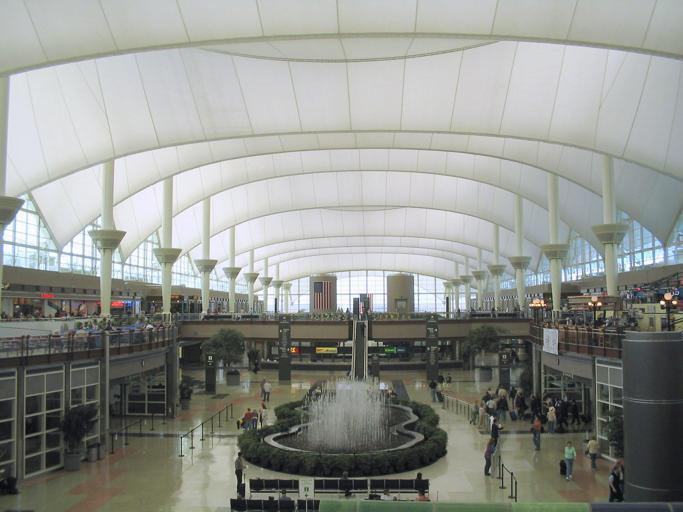

In [ ]:
image = Image.open('/content/ADE20k_toy_dataset/images/training/ADE_train_00000001.jpg')
image

In [ ]:
# prepare the image for the model
encoding = feature_extractor(image, return_tensors="pt")
pixel_values = encoding.pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [ ]:
# forward pass
outputs = model(pixel_values=pixel_values)

In [ ]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 150, 128, 128])


In [ ]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

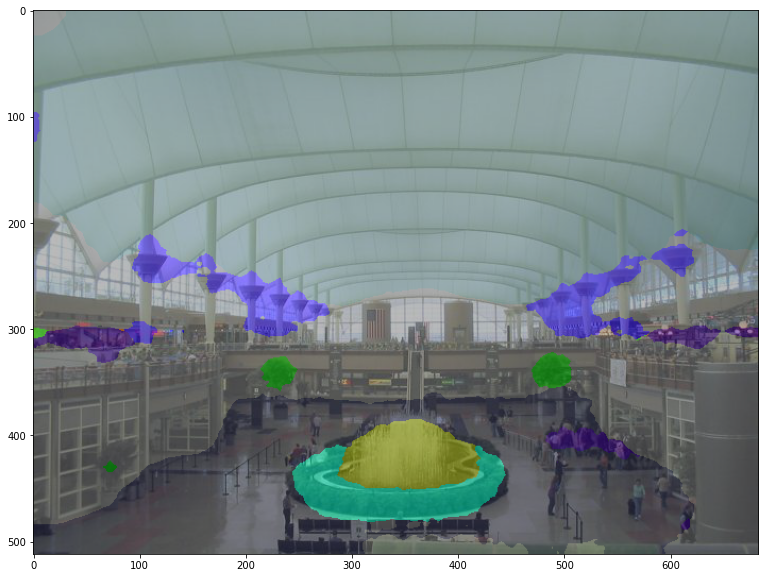

In [ ]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare this to the ground truth segmentation map:

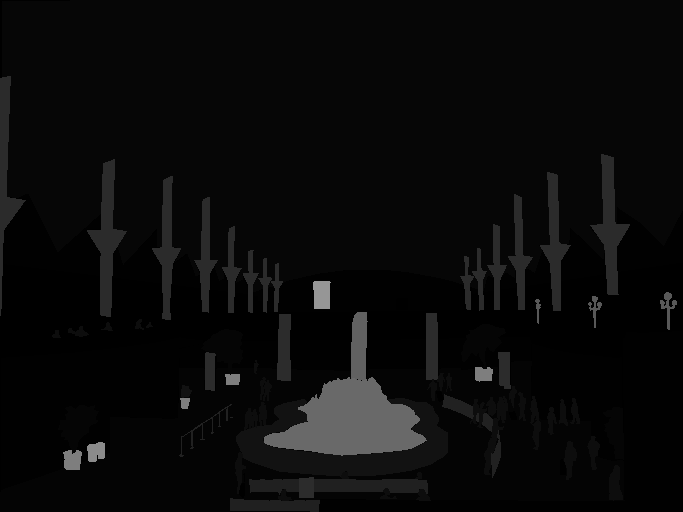

In [ ]:
map = Image.open('/content/ADE20k_toy_dataset/annotations/training/ADE_train_00000001.png') 
map 

Classes in this image: ['wall', 'floor', 'tree', 'ceiling', 'person', 'plant', 'seat', 'fence', 'column', 'signboard', 'streetlight', 'escalator', 'fountain', 'pot', 'ashcan', 'flag', None]


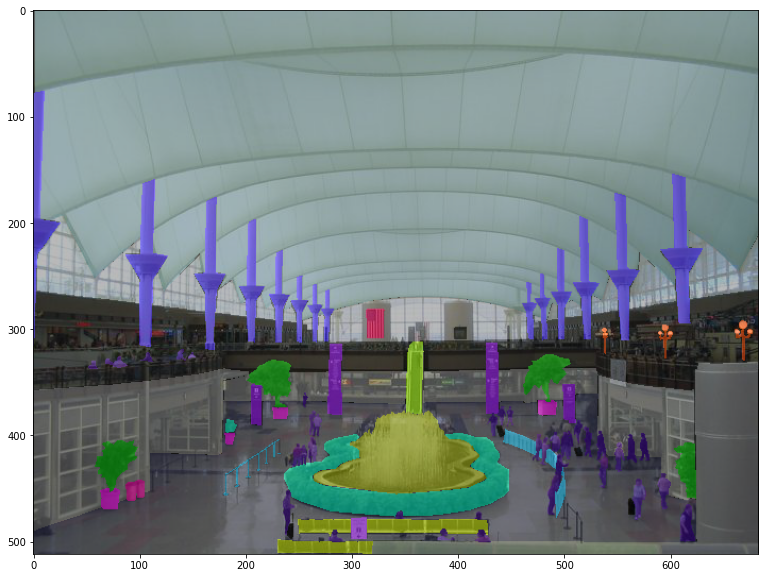

In [ ]:
# convert map to NumPy array
map = np.array(map)
map[map == 0] = 255 # background class is replaced by ignore_index
map = map - 1 # other classes are reduced by one
map[map == 254] = 255

classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [ ]:
seg.unique()

tensor([  0,   3,   4,   5,  12,  14,  17,  42, 104, 145])

In [ ]:
model.config.id2label[37]

'bathtub'

In [ ]:
np.unique(map)

array([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104,
       125, 138, 149, 255], dtype=uint8)

In [ ]:
seg

tensor([[0, 0, 0,  ..., 5, 5, 5],
        [0, 0, 0,  ..., 5, 5, 5],
        [0, 0, 0,  ..., 5, 5, 5],
        ...,
        [3, 3, 3,  ..., 0, 0, 0],
        [3, 3, 3,  ..., 0, 0, 0],
        [3, 3, 3,  ..., 0, 0, 0]])

In [ ]:
map

array([[255, 255, 255, ...,   5,   5,   5],
       [255, 255,   5, ...,   5,   5,   5],
       [255, 255,   5, ...,   5,   5,   5],
       ...,
       [  3,   3,   3, ...,   0,   0, 255],
       [  3,   3,   3, ...,   0,   0, 255],
       [  3,   3,   3, ...,   0,   0,   0]], dtype=uint8)

Let's compute the metrics:

In [ ]:
# metric expects a list of numpy arrays for both predictions and references
metrics = metric.compute(predictions=[seg.numpy()], references=[map], num_labels=150, ignore_index=255)

/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:258: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label


In [ ]:
metrics.keys()

dict_keys(['mean_iou', 'mean_accuracy', 'overall_accuracy', 'per_category_iou', 'per_category_accuracy'])

In [ ]:
import pandas as pd

# print overall metrics
for key in list(metrics.keys())[:3]:
  print(key, metrics[key])

# pretty-print per category metrics as Pandas DataFrame
metric_table = dict()
for id, label in id2label.items():
    metric_table[label] = [
                           metrics["per_category_iou"][id],
                           metrics["per_category_accuracy"][id]
    ]

print("---------------------")
print("per-category metrics:")
pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])

mean_iou 0.267017166760567
mean_accuracy 0.3319280229878207
overall_accuracy 0.8720172297308013
---------------------
per-category metrics:


,IoU,accuracy
wall,0.742405,0.919704
building,NaN,NaN
sky,NaN,NaN
floor,0.702580,0.940764
tree,0.346969,0.366607
...,...,...
shower,NaN,NaN
radiator,NaN,NaN
glass,NaN,NaN
clock,NaN,NaN
